# An introductory note

This notebook serves as the one place where you can find out everything about bioscrape inference -- use cases, features, debugging, and development. A basic familiarity with probability distributions, Bayesian inference and Markov Chain Monte Carlo (MCMC) is assumed. To learn about the internal programming details of running an MCMC algorithm, refer to the `emcee_tutorial.ipynb`. 

# Let's start with a simple example - A linear model

Consider the linear model: y = mx + b and let's create an artificial data set for this model by adding noise to its simulation:

(this example is taken from emcee package documentation and modified to be used with bioscrape inference)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

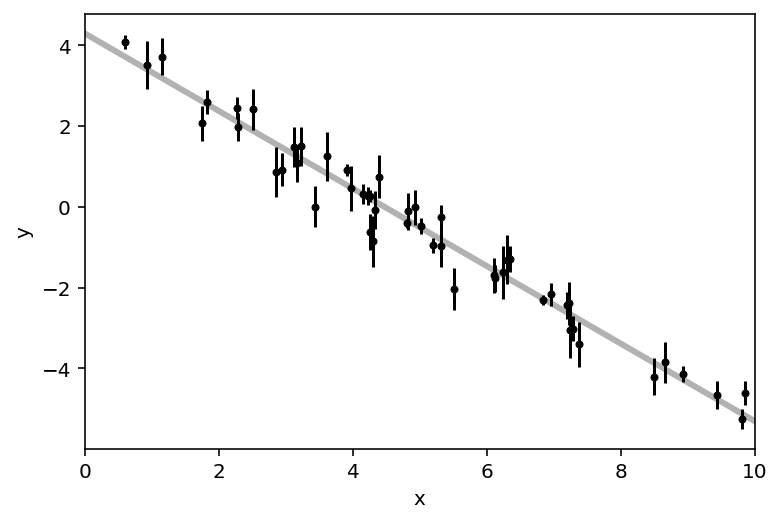

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
# f_true = 0.534
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

species = ['y']
parameters = {'m':m_true, 'b': b_true}
rule = ('assignment',{'equation':'y = _m*t + _b'})
x0 = {'y':0}
M = Model(species = species, parameters = parameters, rules = [rule], initial_condition_dict = x0)


#Simulate the Model deterministically
x0 = np.linspace(0, 10, 50)
results_det = py_simulate_model(x0, Model = M) #Returns a Pandas DataFrame

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.6 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 50)
plt.plot(x0, results_det['y'], "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

Bioscrape uses Pandas dataframe to provide simulation results and also to load data. Here's how to create a Pandas dataframe object for our artificial data above:


In [3]:
import pandas as pd
exp_data = pd.DataFrame()
exp_data['x'] = x0
exp_data['y'] = y
exp_data

x         y
0    0.000000  4.081221
1    0.204082  3.508320
2    0.408163  3.715964
3    0.612245  2.069505
4    0.816327  2.598509
5    1.020408  2.450301
6    1.224490  1.986717
7    1.428571  2.415742
8    1.632653  0.870627
9    1.836735  0.922192
10   2.040816  1.488469
11   2.244898  1.078741
12   2.448980  1.500471
13   2.653061  0.003086
14   2.857143  1.254209
15   3.061224  0.921554
16   3.265306  0.461417
17   3.469388  0.322563
18   3.673469  0.273595
19   3.877551 -0.617154
20   4.081633  0.270673
21   4.285714 -0.853026
22   4.489796 -0.070654
23   4.693878  0.750092
24   4.897959 -0.400697
25   5.102041 -0.111331
26   5.306122 -0.002814
27   5.510204 -0.466162
28   5.714286 -0.952946
29   5.918367 -0.977699
30   6.122449 -0.237656
31   6.326531 -2.038581
32   6.530612 -1.687473
33   6.734694 -1.770167
34   6.938776 -1.613105
35   7.142857 -1.306913
36   7.346939 -1.286608
37   7.551020 -2.310348
38   7.755102 -2.158146
39   7.959184 -2.439218
40   8.163265 -2.389050
41   8.367347 -3.049601
42   8.571429 -3.013212
43   8.775510 -3.399634
44   8.979592 -4.200313
45   9.183673 -3.851695
46   9.387755 -4.132080
47   9.591837 -4.654510
48   9.795918 -5.249679
49  10.000000 -4.608701

## Now we are ready to use bioscrape inference to estimate parameter distributions for our linear model given the artificial data:

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 226.25it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([31.97829852, 29.79149282]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.713 , 0.717 , 0.7305, 0.703 , 0.7275, 0.7135, 0.715 , 0.717 ,
       0.6985, 0.7185, 0.7345, 0.7135, 0.723 , 0.698 , 0.7085, 0.7325,
       0.697 , 0.7175, 0.7255, 0.727 , 0.709 , 0.728 , 0.7195, 0.701 ,
       0.7225, 0.713 , 0.7215, 0.721 , 0.725 , 0.7215, 0.7135, 0.7085])}
Parameter posterior distribution convergence plots:


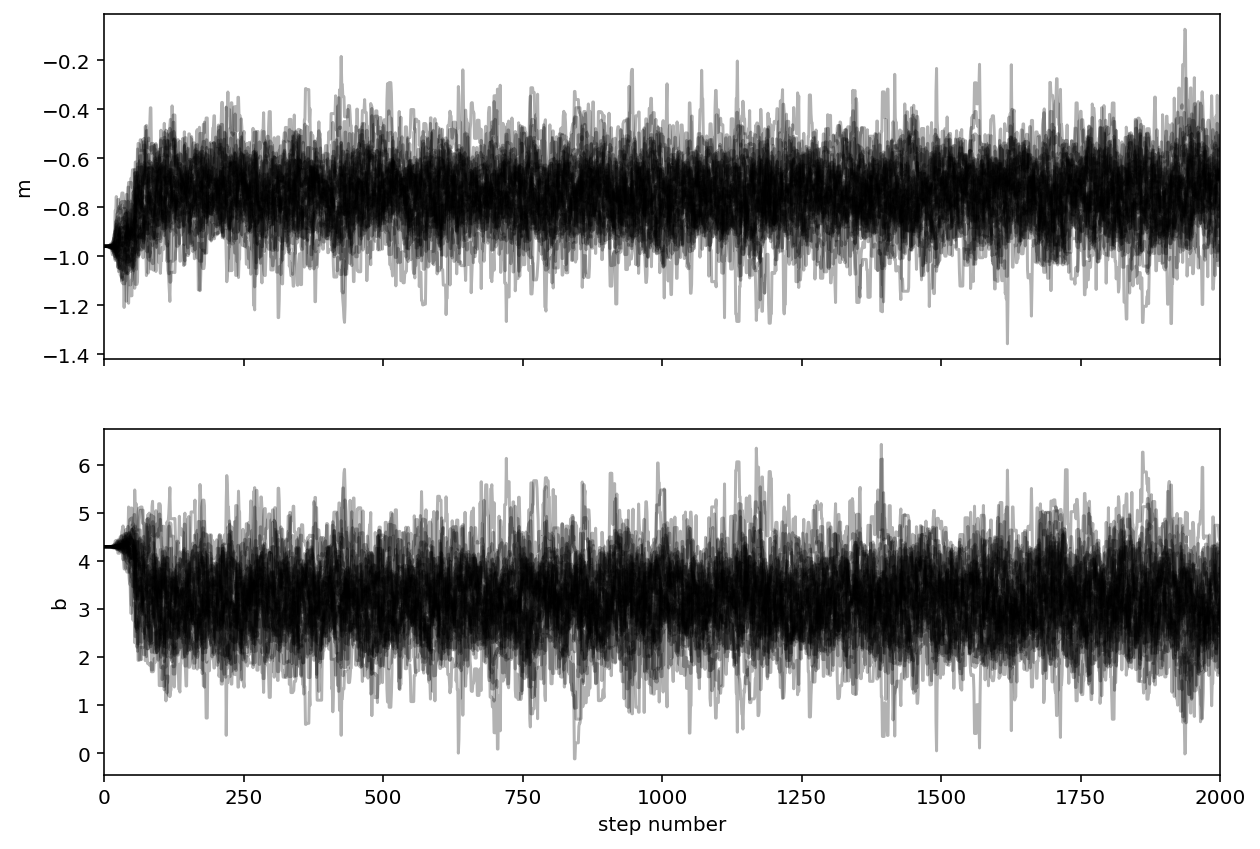

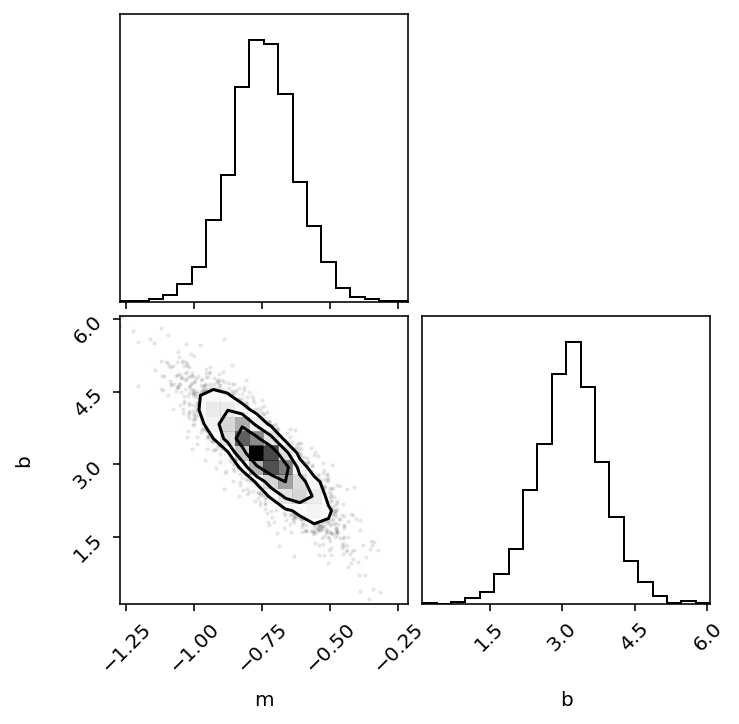

In [4]:
# from bioscrape.pid_interfaces import 
from bioscrape.inference import py_inference

# Import data from CSV
# Import a CSV file for each experiment run
prior = {'m' : ['gaussian', m_true, 500],'b' : ['gaussian', b_true, 1000]}
sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['y'],
                     time_column = ['x'], params_to_estimate = ['m','b'],
                      nwalkers = 32, nsteps = 2000, init_seed = 1e-4, prior = prior,
                      sim_type = 'deterministic', plot_show = False)

# Recommended to simply use sampler object/mcmc_results.csv and generate your own custom plots
truth_list, uncertainty_list = pid.plot_mcmc_results(sampler);

Finally, let us use the samples from the posterior distributions of the parameters alongside our original model and the data:

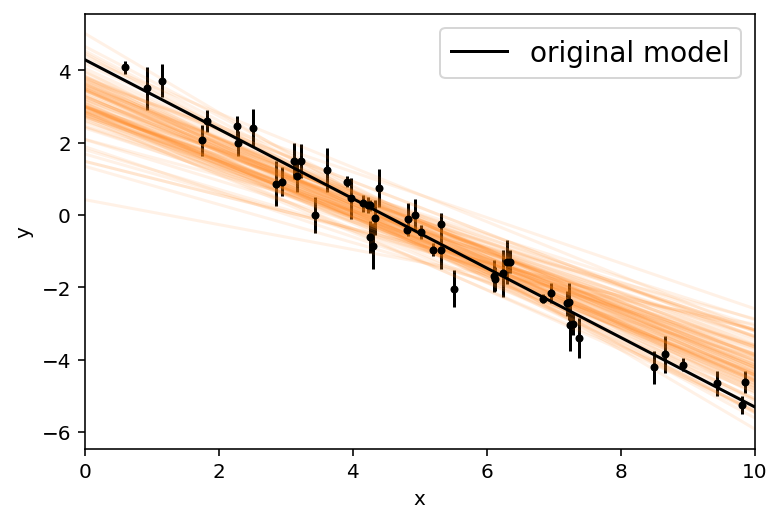

In [5]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="original model")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Great! That's our first MCMC run using Bioscrape. Let us try some more examples to learn about various Bioscrape Inference features. We start by making a slightly more complicated model:

# A Birth-Death Model

## $\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

This time instead of creating the model from scratch, we import an **SBML** model into Bioscrape. SBML is the standard language used to write biological models. Here we have the SBML file "toy_sbml_model.xml" in our path already. For details on how to create this file using Bioscrape, refer to the "Basic Examples -- START HERE.ipynb" in `bioscrape/examples`. 

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 594.51it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([34.90999633]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.796     , 0.81166667, 0.79733333, 0.79433333, 0.80466667])}
Parameter posterior distribution convergence plots:


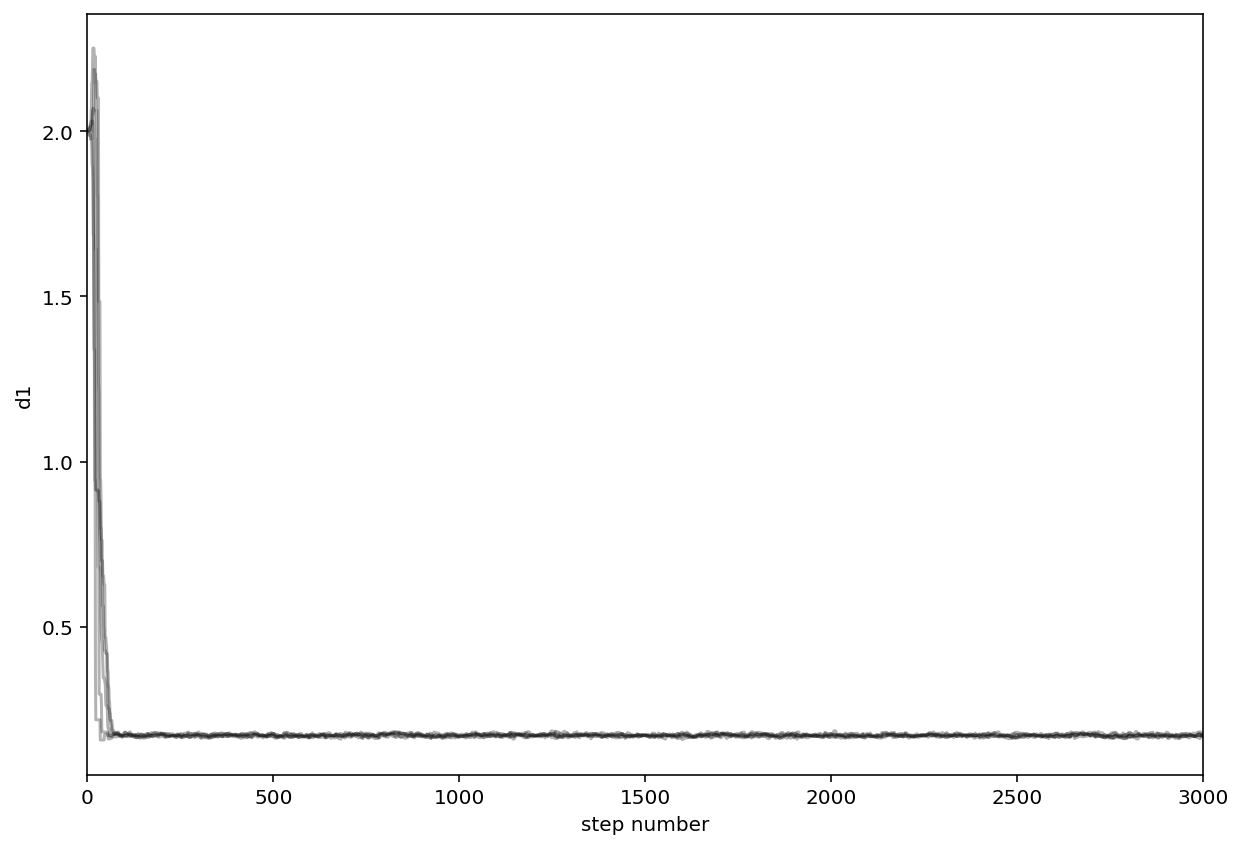

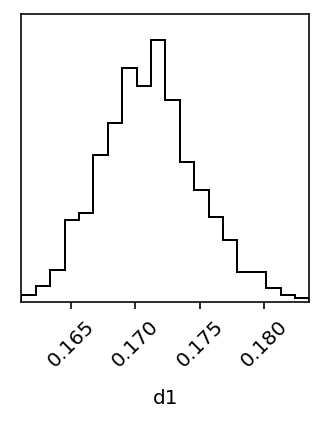

In [6]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.inference import py_inference
import numpy as np
import pylab as plt
import pandas as pd
# Import a bioscrape/SBML model
M = Model(sbml_filename = 'models/toy_sbml_model.xml')
# Import data from CSV
# Import a CSV file for each experiment run
df = pd.read_csv('data/test_data.csv', delimiter = '\t', names = ['X','time'], skiprows = 1)
M.set_species({'X':df['X'][0]})

# Create prior for parameters
prior = {'d1' : ['gaussian', 0.2, 200]}
sampler, pid = py_inference(Model = M, exp_data = df, measurements = ['X'], time_column = ['time'],
            nwalkers = 5, init_seed = np.array([2]), nsteps = 3000, sim_type = 'deterministic',
            params_to_estimate = ['d1'], prior = prior)


Note that we only estimated one parameter here - $d$, and for that parameter we created a Gaussian distribution prior. Bioscrape inference provides plenty of probability distributions built-in to be used as parameter prior distributions. To learn more refer to the "Priors in Bioscrape Inference.ipynb" in `bioscrape/inference examples/`. Now, let us try to estimate both the parameters of our birth-death model:

100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:33<00:00, 164.49it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([60.93395525, 60.64220591]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.65581818, 0.64618182, 0.64618182, 0.62872727, 0.64309091,
       0.66127273, 0.63436364, 0.64236364, 0.64      , 0.65      ,
       0.64381818, 0.63272727, 0.64109091, 0.65      , 0.63836364,
       0.62072727, 0.652     , 0.62909091, 0.64145455, 0.656     ])}
Parameter posterior distribution convergence plots:


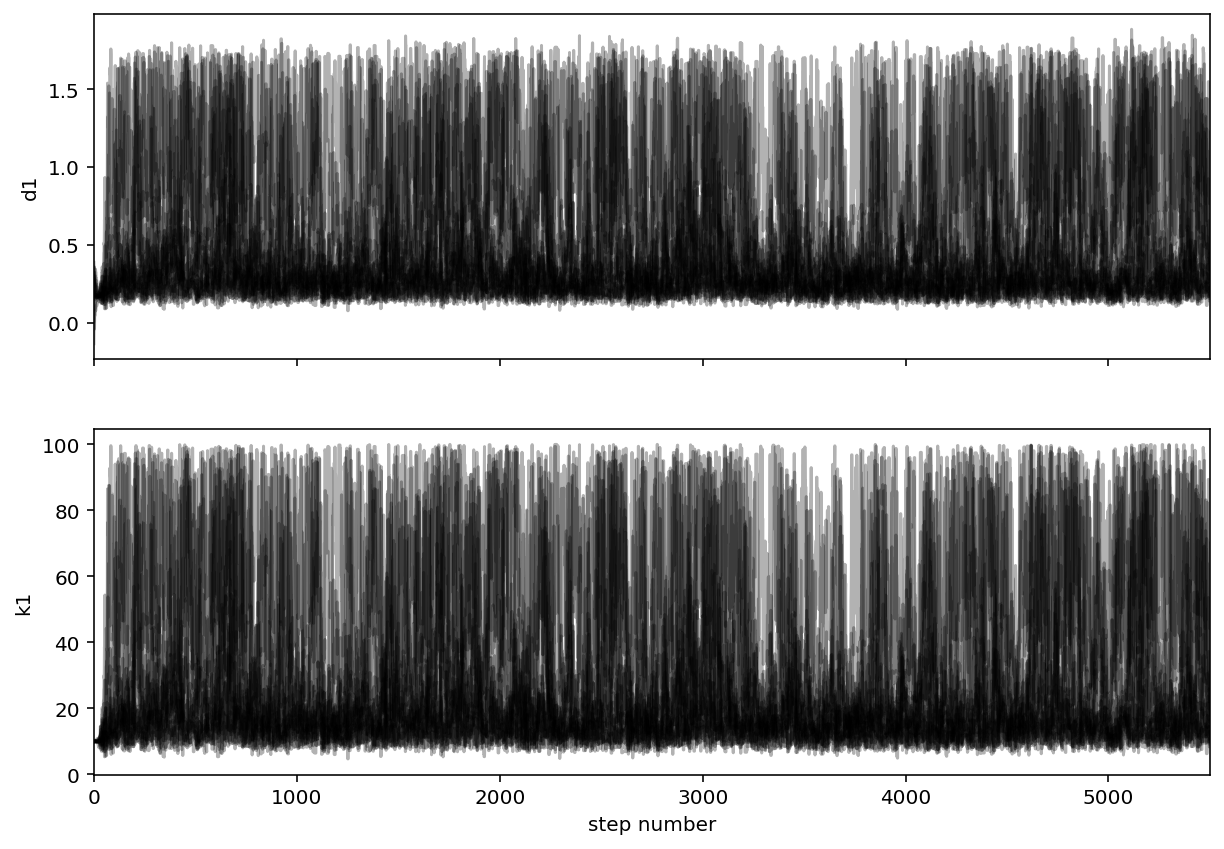

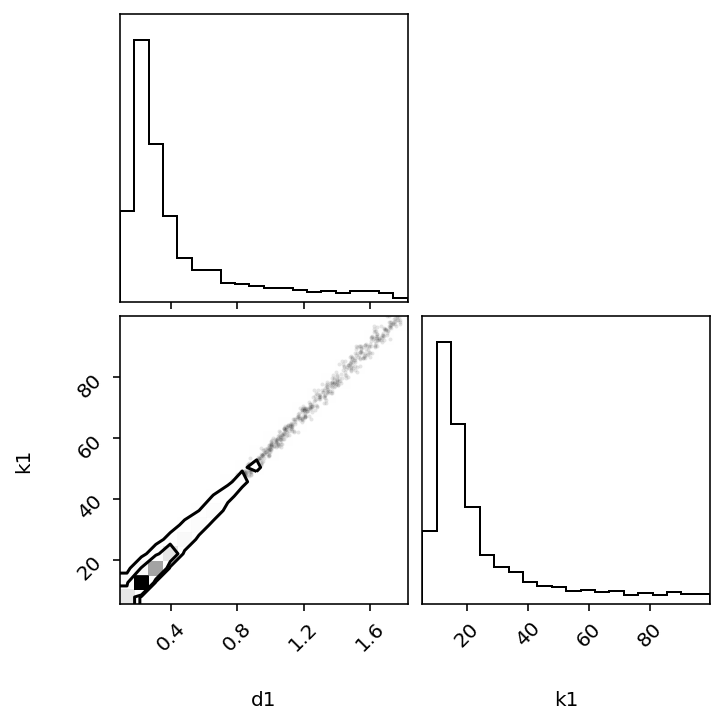

In [7]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.inference import py_inference

import numpy as np
import pylab as plt
import pandas as pd
# Import a bioscrape/SBML model
M = Model(sbml_filename = 'models/toy_sbml_model.xml')
# Import data from CSV
# Import a CSV file for each experiment run
df = pd.read_csv('data/test_data.csv', delimiter = '\t', names = ['X','time'], skiprows = 1)
M.set_species({'X':df['X'][0]})

prior = {'d1' : ['gaussian', 0.2, 20], 'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = df, measurements = ['X'], time_column = ['time'],
            nwalkers = 20, init_seed = 0.15, nsteps = 5500, sim_type = 'deterministic',
            params_to_estimate = ['d1', 'k1'], prior = prior)


## Tip: All of the MCMC run results are written to the `mcmc_results.csv` file after a run. You can check that file out to run your own analysis!.

A common scenario with parameter estimation is that we usually have replicates of the data leading to multiple trajectories in the data that need to be fitted to a single model at the same time. Bioscrape inference allows for such a use case natively. Simply send in more data! Here's how: (let's first generate data with multiple trajectories)

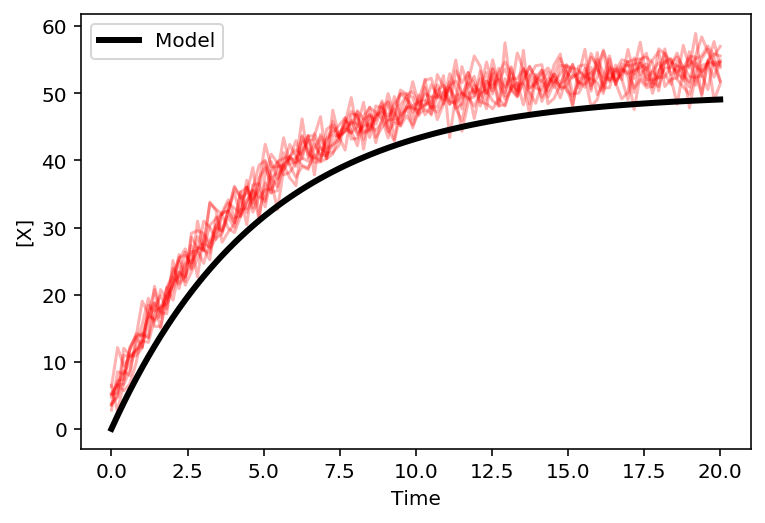

In [8]:

M = Model(sbml_filename = 'models/toy_sbml_model.xml')
timepoints = np.linspace(0,20,100)
result = py_simulate_model(timepoints, Model = M)['X']

num_trajectories = 10
exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result + np.random.normal(5, 2, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
plt.plot(timepoints, result, 'k', linewidth = 3, label = 'Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()


In [9]:
exp_data.to_csv('data/birth_death_data.csv')
exp_data

timepoints         X0         X1         X2         X3         X4  \
0     0.000000   2.799868   3.560234   5.160689   3.548884   6.502809   
1     0.202020   8.506323   6.718474   6.544544   4.940812   2.511285   
2     0.404040   8.191093   8.595812   5.670414  10.966159   7.016502   
3     0.606061  11.825547   7.949569   6.699974  10.777037  11.809987   
4     0.808081  14.180350  13.651403   9.781317  10.915126  13.667237   
5     1.010101  13.969121  12.197476  14.288882  12.026083  19.022941   
6     1.212121  16.813261  18.415543  13.663521  17.377166  17.152812   
7     1.414141  16.353548  17.549449  21.242575  18.826643  20.757539   
8     1.616162  18.167308  18.079137  17.518490  14.981274  16.625084   
9     1.818182  18.657442  19.792680  19.342427  20.873155  20.998460   
10    2.020202  20.730025  21.322940  21.713311  22.604657  23.232351   
11    2.222222  23.348040  25.540646  22.762297  21.592796  25.280857   
12    2.424242  22.597718  25.869622  26.317870  22.633169  26.821695   
13    2.626263  27.312271  24.721851  23.947601  28.557139  23.796742   
14    2.828283  22.640982  26.881977  30.958735  26.878328  27.064802   
15    3.030303  28.885579  26.866722  26.575009  27.778694  26.583903   
16    3.232323  26.780684  25.194932  26.221234  33.600678  33.800464   
17    3.434343  28.437291  31.599796  30.445980  32.744322  32.532327   
18    3.636364  29.037713  29.633925  29.403360  31.939410  27.821712   
19    3.838384  32.596589  32.388804  31.575112  33.682369  29.356158   
20    4.040404  35.956390  30.763376  29.947686  32.890267  30.553762   
21    4.242424  34.641450  33.285151  32.663211  31.973964  35.238289   
22    4.444444  30.431013  35.991774  32.830063  36.072640  36.038202   
23    4.646465  36.363271  33.642050  35.776772  32.289492  34.179825   
24    4.848485  36.560169  37.416907  39.291723  34.491858  36.631719   
25    5.050505  33.868188  38.911402  40.018012  34.211679  42.399699   
26    5.252525  38.394434  36.862333  35.268582  39.825310  39.080699   
27    5.454545  39.834473  32.681459  35.500726  37.274115  39.030061   
28    5.656566  40.317219  38.608568  41.172513  39.481887  39.370833   
29    5.858586  40.564447  40.556066  39.235357  40.391766  37.403712   
..         ...        ...        ...        ...        ...        ...   
70   14.141414  51.862646  49.414063  51.564226  54.277344  51.989173   
71   14.343434  51.051076  51.287861  50.361806  49.440522  53.172837   
72   14.545455  54.255377  52.849363  52.021776  51.679629  50.853879   
73   14.747475  55.863561  51.540140  51.043048  49.337008  54.134908   
74   14.949495  50.445693  53.287903  50.767654  52.323468  54.126799   
75   15.151515  49.573274  47.995474  48.363141  54.293363  49.951222   
76   15.353535  51.509596  54.049373  52.268382  51.609203  50.036022   
77   15.555556  52.370525  54.259267  52.503139  51.377140  51.914962   
78   15.757576  52.151074  50.325539  55.939967  52.416135  55.403485   
79   15.959596  51.595053  55.068056  53.998369  53.689404  54.093676   
80   16.161616  49.982438  53.178900  50.384882  52.399694  56.242677   
81   16.363636  53.619369  52.035213  55.140932  51.959350  51.760448   
82   16.565657  51.548028  53.227561  51.297433  53.659678  52.745655   
83   16.767677  49.167631  53.959668  53.448782  52.046843  53.595195   
84   16.969697  50.207676  52.467952  52.953487  56.543958  53.288080   
85   17.171717  55.271728  47.587573  53.388673  52.904892  50.751043   
86   17.373737  52.796711  52.650775  53.867878  54.522698  52.016367   
87   17.575758  53.887770  51.196324  54.381554  53.523216  50.864466   
88   17.777778  50.010380  51.619549  50.903747  54.982943  51.049150   
89   17.979798  53.012410  53.488259  56.633588  56.220415  52.695853   
90   18.181818  55.998728  54.655813  55.902524  51.018401  56.619471   
91   18.383838  54.640432  54.369902  52.809921  52.112152  52.230872   
92   18.585859  54.115331  55.430983  54.030029  52.282237  48

With that data written to a CSV file, we can load that CSV file and run inference:

  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\moves\red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:52<00:00, 76.08it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([53.60954302, 50.29166161]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.70675, 0.7115 , 0.711  , 0.6975 , 0.71625])}
Parameter posterior distribution convergence plots:


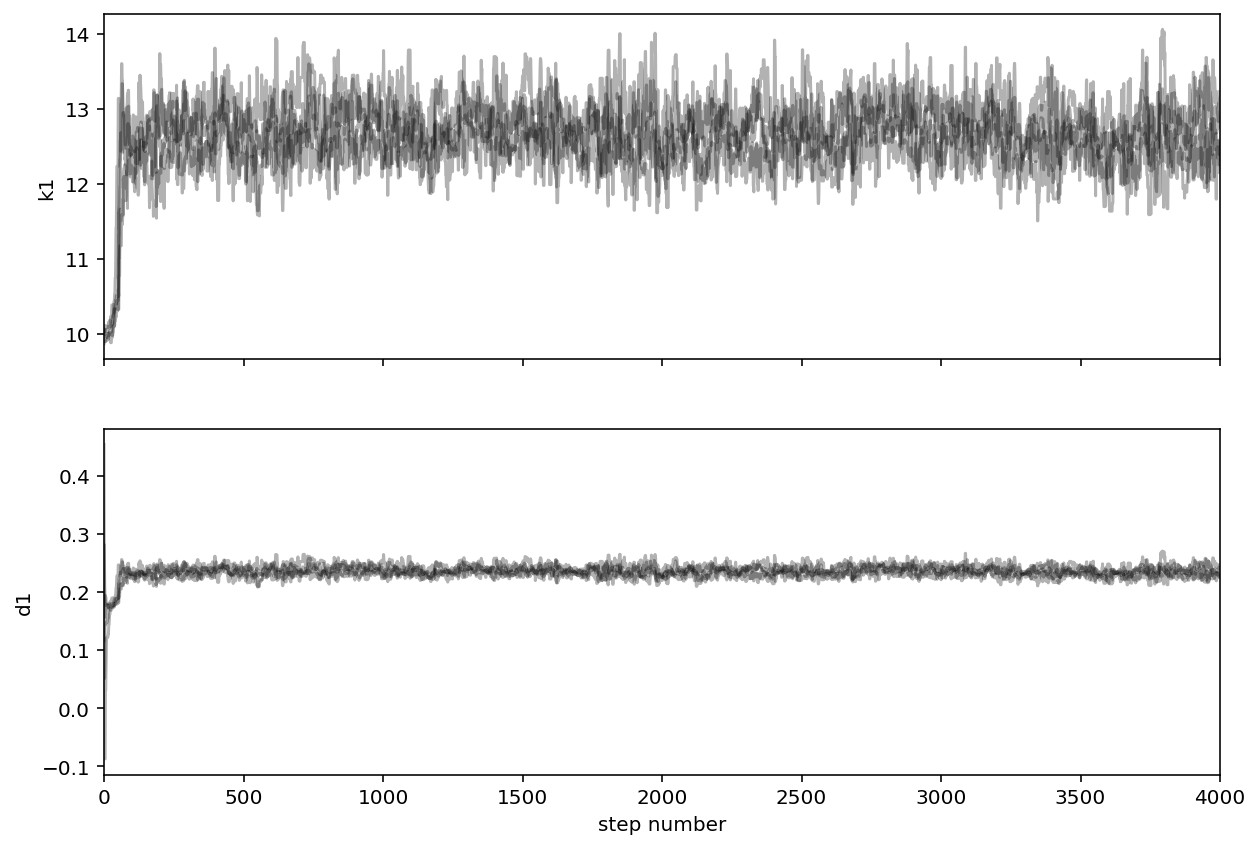

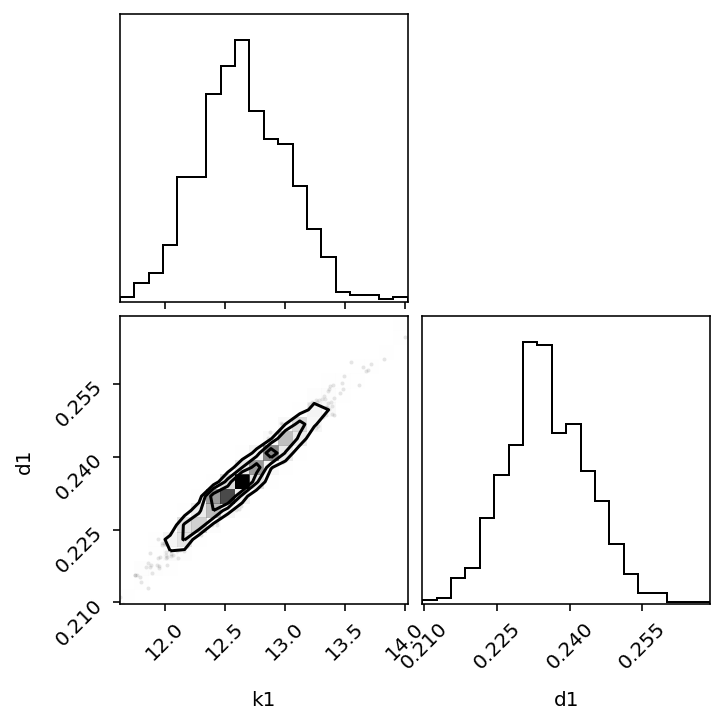

In [10]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
 
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
            nwalkers = 5, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
            params_to_estimate = ['k1', 'd1'], prior = prior)


### Note: A bioscrape inference run using `py_inference` returns a tuple consisting of the `sampler` and a `pid` object. The `sampler` is a emcee object that can be used for any post-processing whereas `pid` is the bioscrape inference object that consists of all of your previous settings. You can use these returned objects for post processing and plotting as follows:

Parameter posterior distribution convergence plots:


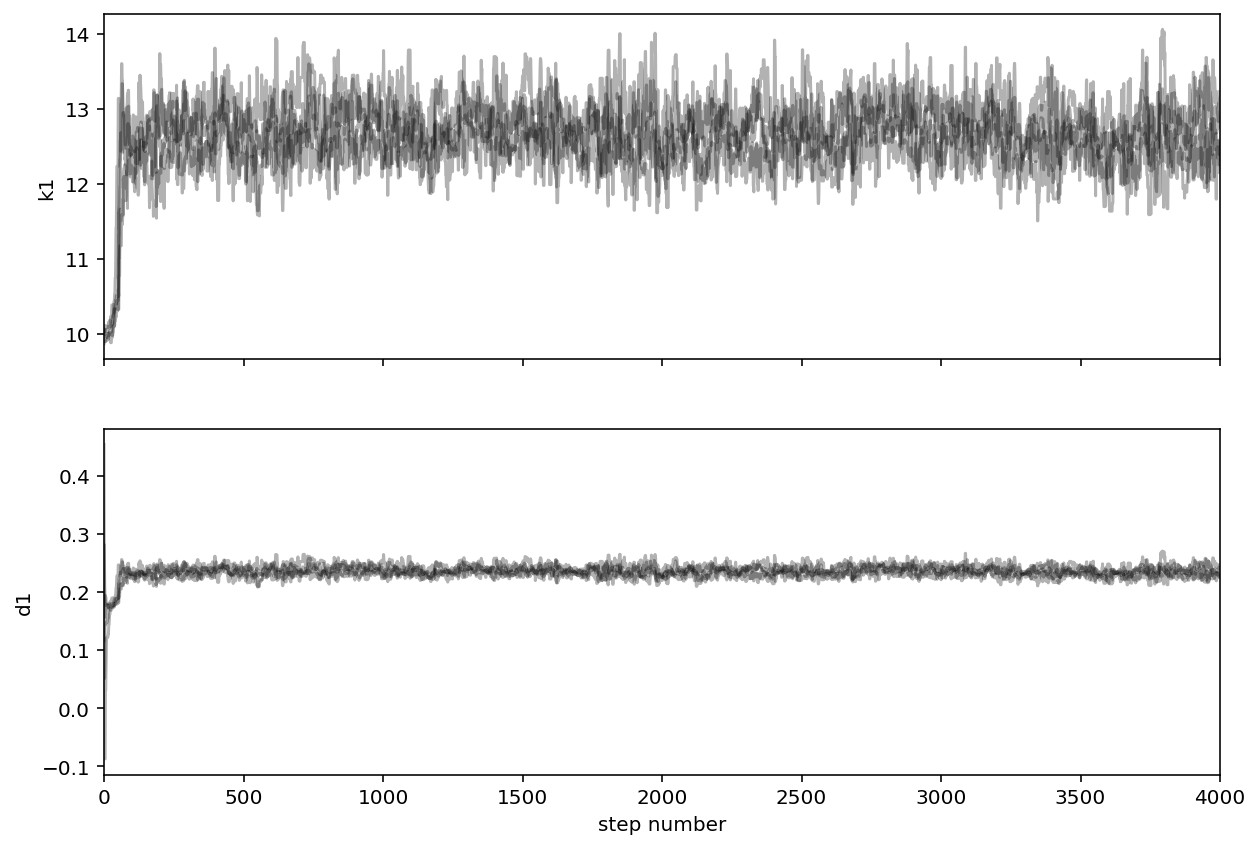

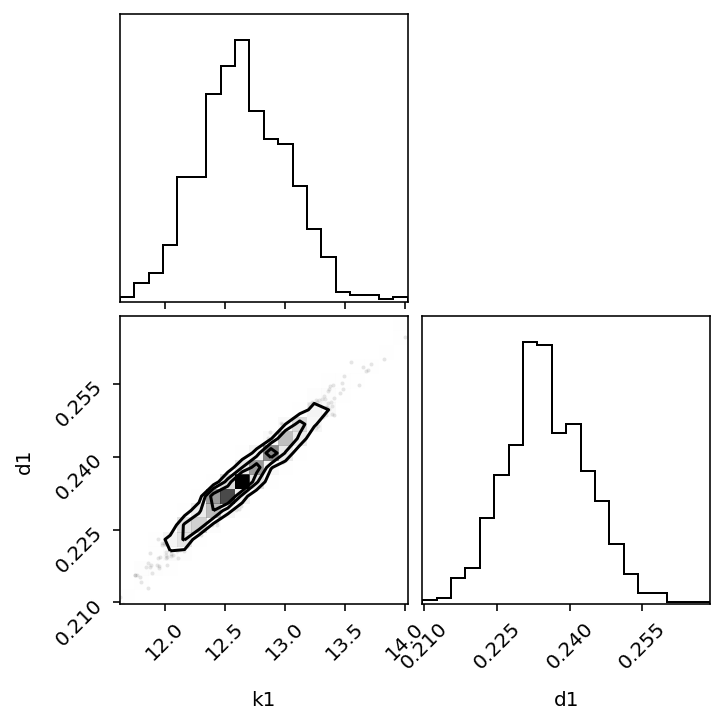

In [11]:
pid.plot_mcmc_results(sampler);

As before, we can sample the posterior distribution and run the simulations for this fitted model alongside the data:

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Depricated Warning: Bioscrape XML is being replaced by SBML and will no longer be supported in a future version of the software.
  """Entry point for launching an IPython kernel.


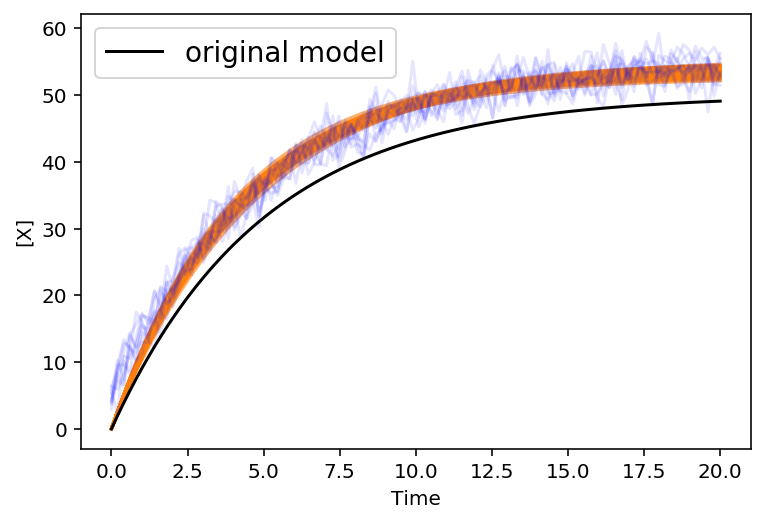

In [14]:
M_fit = Model('models/toy_model.xml')
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    for pi, pi_val in zip(pid.params_to_estimate, sample):
        M_fit.set_parameter(pi, pi_val)
    plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
plt.plot(timepoints, result, "k", label="original model")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

# Starting the MCMC chain at different initial points (init_seed):

The `init_seed` keyword argument to `py_inference` can be either of the two things:
* A float value - In this case, the float value passed is used as the scaling factor for a Gaussian ball around the initial parameter values already set in the Bioscrape Model object.
* A numpy array - In this case, you can directly pass the initial parameter values to the sampler. This array consists of the values where the sampler starts sampling.

## Tip: Start at different initial conditions for your parameters and if you end up in the same region you can have higher confidence on convergence of your chain.

Let's try a different initial seed for the above example

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:01<00:00, 80.74it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([71.38771031, 39.74573695]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.6946, 0.7144, 0.7076, 0.7022, 0.711 ])}
Parameter posterior distribution convergence plots:


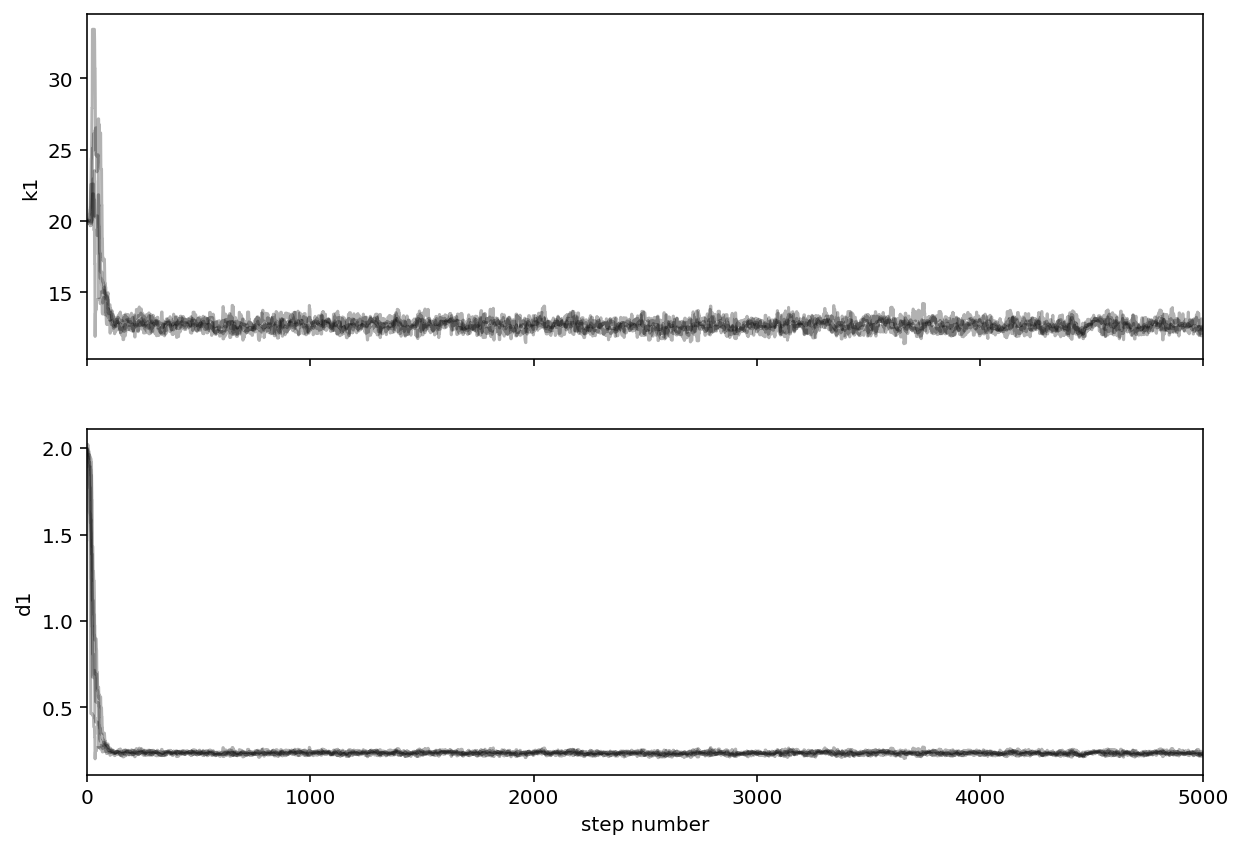

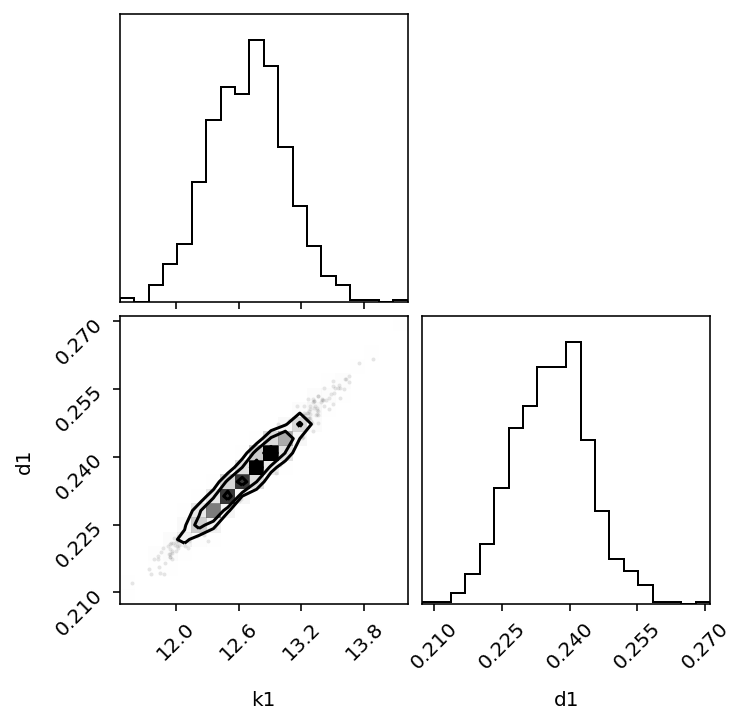

In [13]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
 
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
            nwalkers = 5, init_seed = np.array([20, 2]), nsteps = 5000, sim_type = 'deterministic',
            params_to_estimate = ['k1', 'd1'], prior = prior)


## An inner look:

Bioscrape inference computes a cost that is used as the likelihood function for emcee. The MCMC chain aims to minimize this cost. An invaluable tool when running Bayesian inference could be to look at the progression of this cost. This may help you in judging the convergence of the MCMC sampler. On the topic of convergence, as you may have noted in our earlier inference runs, a list of convergence related statistics is printed after the run finishes successfully. Make sure to learn more about these MCMC convergence diagnostics to understand better if your inference run has converged or not. Here is how to check the cost progress:

### Likelihood cost progress (with number of steps in the chain):

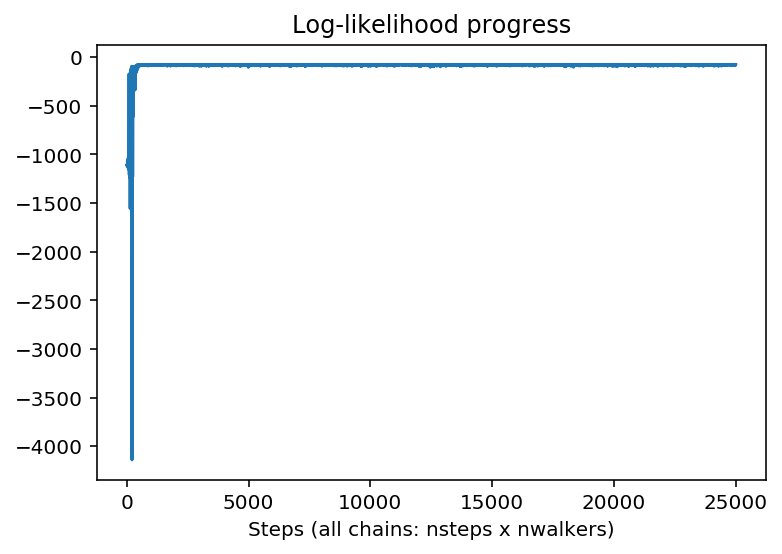

In [16]:
plt.close()
plt.title('Log-likelihood progress')
plt.plot(pid.cost_progress)
plt.xlabel('Steps (all chains: nsteps x nwalkers)')
plt.show()

Now that we have seen how to use multiple data trajectories with bioscrape inference, what if those trajectories are under different initial conditions?

# Multiple Initial Conditions:

In our birth-death model, we introduce an inducer species that we will use to demonstrate the effect of different initial conditions.
## $\emptyset \xrightarrow[]{k_1(I)} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$


## $ k_1(I) = \frac{k_1 I^2}{K_R^2 + I^2}$

Here $I$ is the inducer species that may have different initial conditions. 

In [17]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2})]
k1 = 50.0
d1 = 0.5
params = [('k1', k1), ('d1', d1), ('KR', 20)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

### Generate experimental data for multiple initial conditions
1. Simulate bioscrape model
2. Add Gaussian noise of non-zero mean and non-zero variance to the simulation
3. Create appropriate Pandas dataframes 
4. Write the data to a CSV file

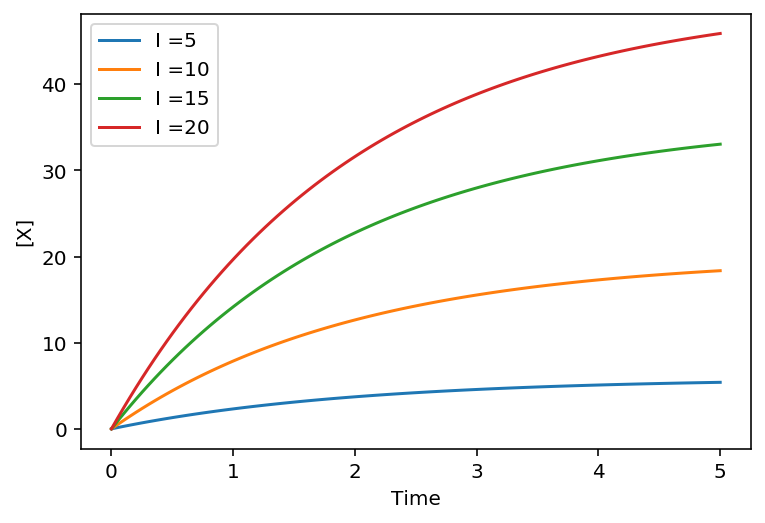

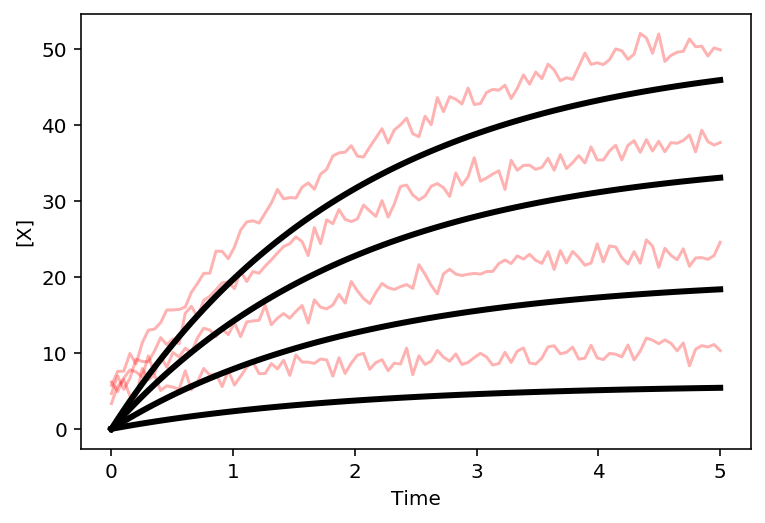

In [18]:

num_trajectories = 4 # each with different initial condition
initial_condition_list = [{'I':5},{'I':10},{'I':15},{'I':20}] 
timepoints = np.linspace(0,5,100)
result_list = []
for init_cond in initial_condition_list:
    M.set_species(init_cond)
    result = py_simulate_model(timepoints, Model = M)['X']
    result_list.append(result)
    plt.plot(timepoints, result, label = 'I =' + str(list(init_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('[X]')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i] + np.random.normal(5, 1, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i], 'k', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
exp_data.to_csv('data/birth_death_data_multiple_conditions.csv')

In [19]:
exp_data

timepoints         X0         X1         X2         X3
0     0.000000   3.328459   6.156242   4.638424   5.699550
1     0.050505   5.590589   4.903016   6.951511   7.556921
2     0.101010   6.504075   6.677415   5.197431   7.579459
3     0.151515   4.335055   7.769208   6.657185   9.918409
4     0.202020   4.165015   7.484934   9.174833   8.531475
5     0.252525   7.928386   6.836118   8.859527  11.298037
6     0.303030   6.466418   9.596502   8.834638  12.994740
7     0.353535   7.080515   7.280382  10.235965  13.118516
8     0.404040   5.047325   9.514265  12.002194  13.979610
9     0.454545   5.652227   8.094568  11.076411  15.639138
10    0.505051   5.489940  10.053424  11.828335  15.644205
11    0.555556   5.209884   9.448906  11.182249  15.709576
12    0.606061   7.630855  10.606305  15.209526  16.028697
13    0.656566   5.141166  10.017849  16.119712  17.963758
14    0.707071   6.177489  11.989950  14.727731  19.144372
15    0.757576   7.942347  13.240939  16.893377  20.455447
16    0.808081   7.055943  12.998758  17.451340  20.477321
17    0.858586   7.234410  12.120836  18.306955  23.377905
18    0.909091   5.550945  13.131116  19.201442  23.350013
19    0.959596   7.671629  12.400941  19.336458  22.392837
20    1.010101   5.753718  13.968970  18.457023  23.912119
21    1.060606   6.899884  12.137956  20.766630  26.144822
22    1.111111   8.130308  14.067808  19.380023  27.230490
23    1.161616   8.808905  14.195499  20.691844  27.374163
24    1.212121   7.262184  14.280805  20.484083  27.081498
25    1.262626   7.286754  16.253441  21.414969  28.401390
26    1.313131   8.578295  13.692306  22.228458  29.709371
27    1.363636   7.892323  14.569354  23.137341  31.506872
28    1.414141   9.025488  15.167168  23.993997  30.270231
29    1.464646   7.031077  14.553414  24.365938  30.434926
..         ...        ...        ...        ...        ...
70    3.535354   9.313629  21.771573  34.409876  46.077306
71    3.585859  10.790883  23.319709  35.596008  47.993567
72    3.636364  10.926924  20.980150  34.038640  47.224772
73    3.686869   9.872839  23.460316  36.097259  45.801779
74    3.737374  10.066070  21.837615  34.244568  46.207752
75    3.787879  10.760915  23.341392  35.033835  45.981047
76    3.838384   9.173413  22.530960  35.958293  47.676814
77    3.888889   9.297946  21.526354  34.984363  49.451696
78    3.939394  10.991528  21.818606  37.094301  47.963176
79    3.989899   9.332594  24.340998  35.381205  48.167008
80    4.040404   9.112791  21.987370  35.390473  47.932241
81    4.090909   9.923270  24.071226  36.572837  48.575613
82    4.141414   9.821388  23.939080  37.321714  49.993831
83    4.191919   9.466968  22.521674  35.393032  49.751918
84    4.242424  11.031028  21.697523  37.308979  48.617353
85    4.292929   9.071493  23.311645  37.921319  49.309351
86    4.343434  10.232251  21.802983  36.387175  52.025324
87    4.393939  11.948791  24.865676  38.057691  51.447826
88    4.444444  11.667458  24.043290  36.557546  49.430132
89    4.494949  11.200772  21.243671  37.839200  51.964915
90    4.545455  11.697746  23.749646  36.460513  48.350641
91    4.595960  11.257170  22.826836  37.664431  49.140615
92    4.646465  10.262787  22.255017  37.579709  49.563175
93    4.696970  11.307829  23.690164  37.950852  49.678696
94    4.747475   8.284465  21.395166  38.672432  51.309239
95    4.797980  10.485170  22.483761  36.445878  50.273584
96    4.848485  10.947453  22.527621  39.303693  50.352300
97    4.898990  10.770962  22.307941  37.795094  49.058373
98    4.949495  11.094893  22.799657  37.341199  50.129456
99    5.000000  10.302995  24.553909  37.677039  49.869043

[100 rows x 5 columns]

## Now run bioscrape inference...

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:19<00:00, 202.15it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([29.11539481]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.79475, 0.79925, 0.799  , 0.7965 , 0.80325])}
Parameter posterior distribution convergence plots:


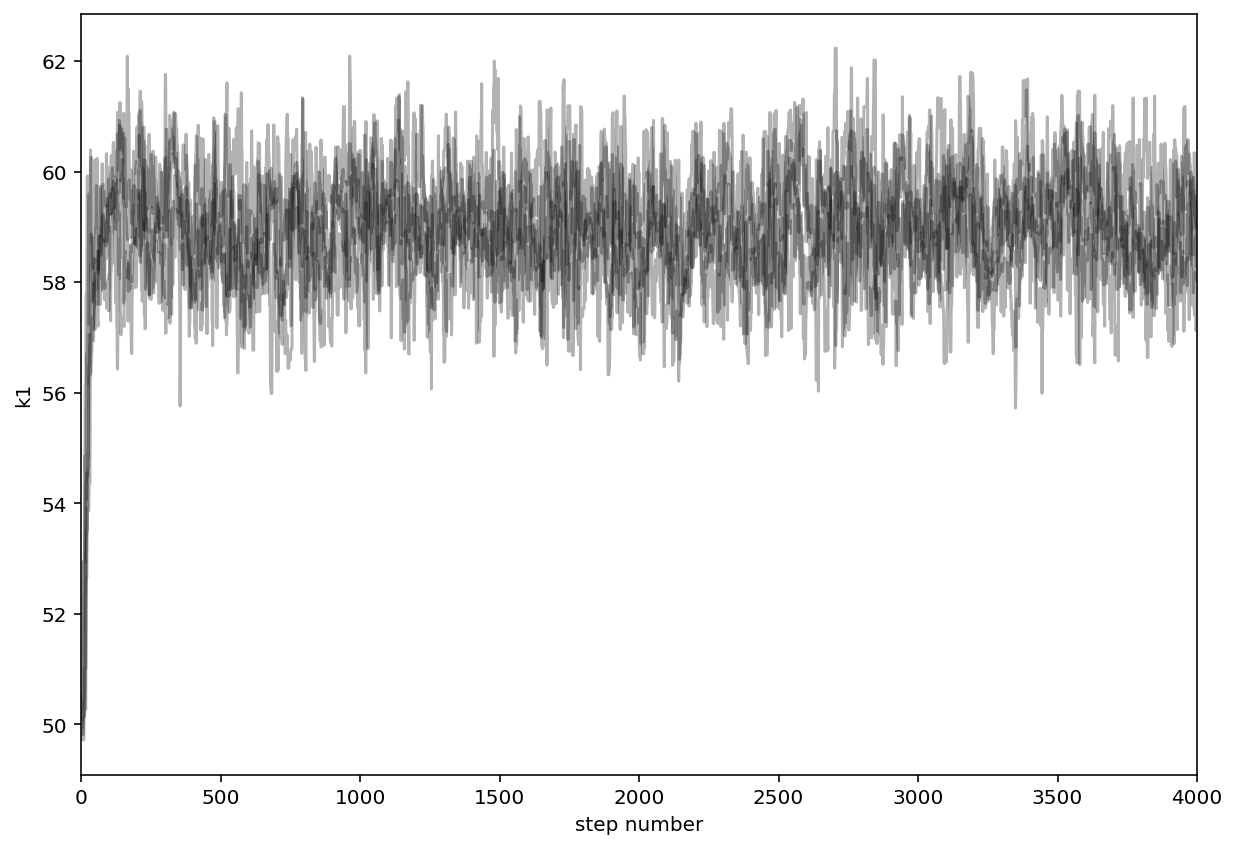

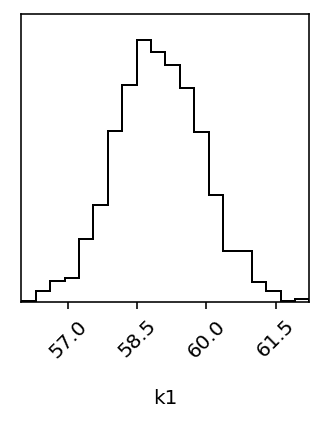

In [20]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data_multiple_conditions.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
    
prior = {'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 5, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
                            params_to_estimate = ['k1'], prior = prior)


As before...

### Check mcmc_results.csv for the results of the MCMC procedure and perform your own analysis.

### OR

### You can also plot the results as follows

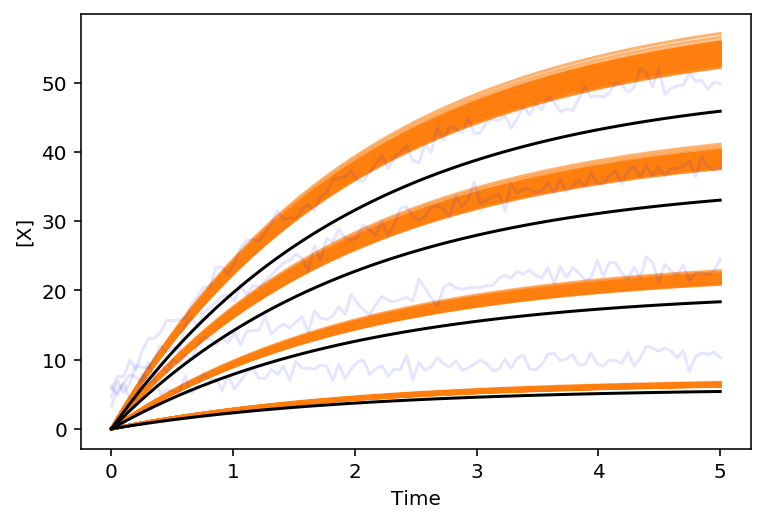

In [21]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for init_cond in initial_condition_list:
    
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        M_fit.set_species(init_cond)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

### Let us now try to fit all three parameters to see if results improve:

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 101.25it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([44.04581226, 41.4513455 , 45.24436385]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.641 , 0.634 , 0.6394, 0.6296, 0.6436, 0.6498, 0.6468, 0.6442,
       0.6458, 0.6368])}
Parameter posterior distribution convergence plots:


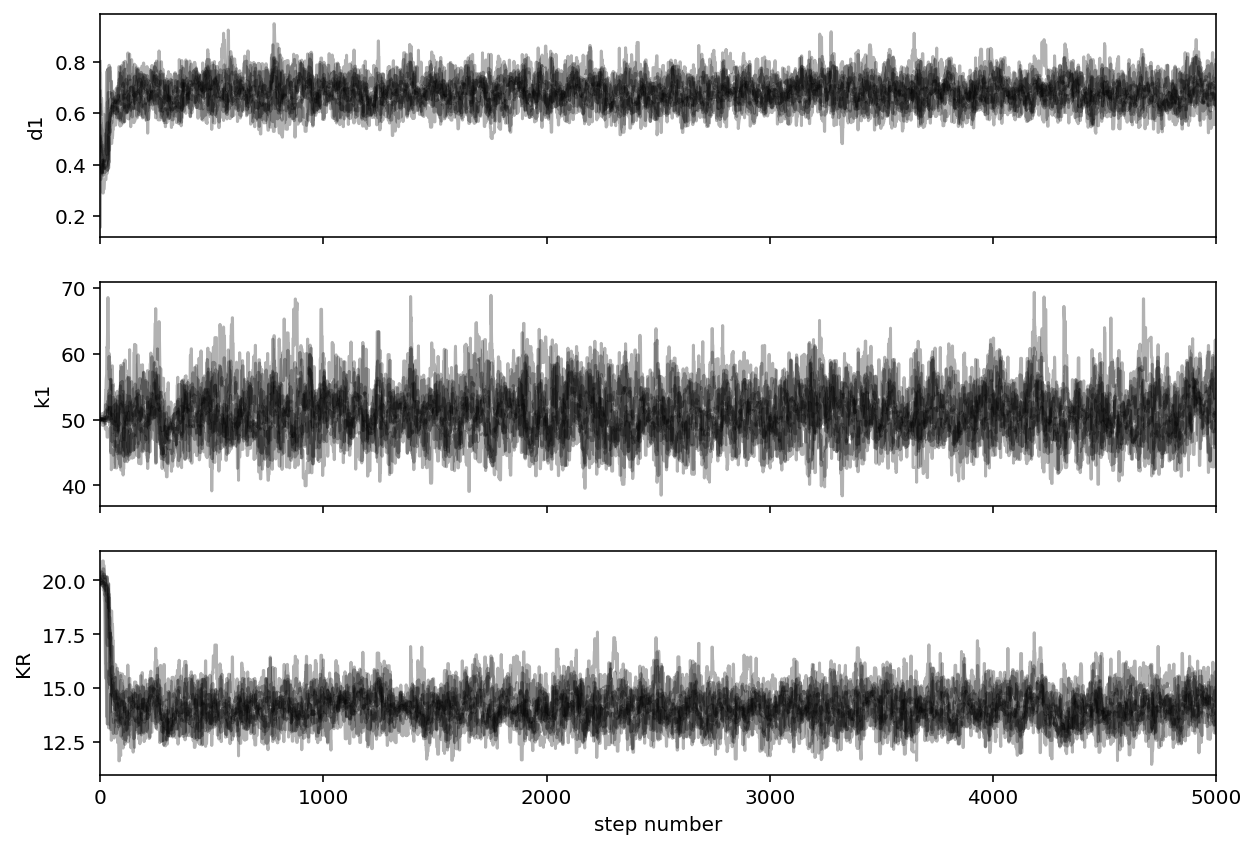

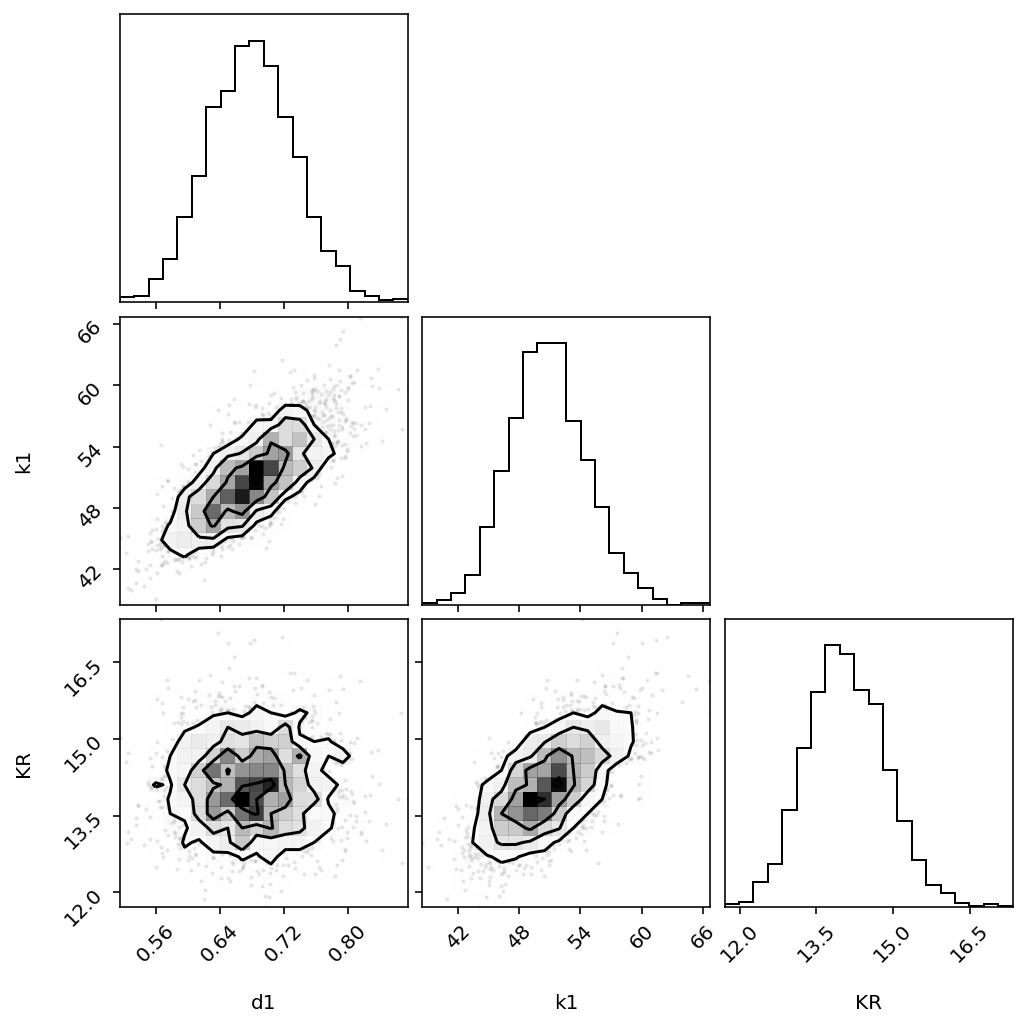

In [22]:
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 10, init_seed = 0.15, nsteps = 5000, sim_type = 'deterministic',
                            params_to_estimate = ['d1','k1','KR'], prior = prior)


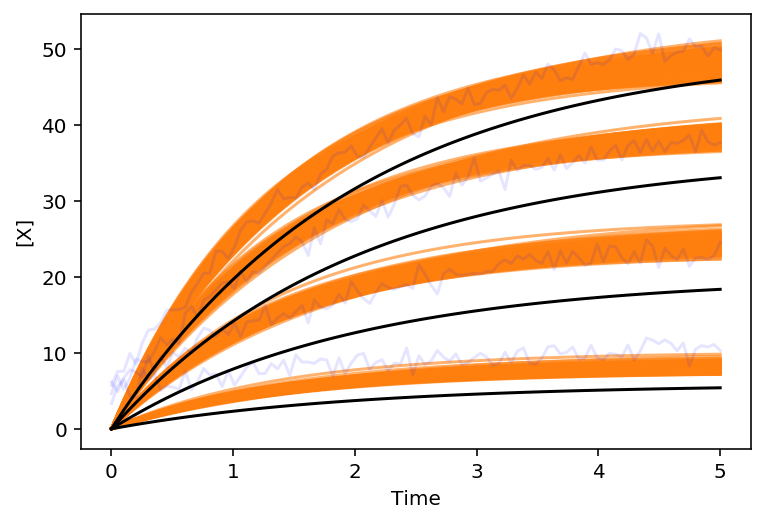

In [23]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for init_cond in initial_condition_list:
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        M_fit.set_species(init_cond)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

In the thread of multiple data trajectories, another common possibility is to have multiple measured species in the data. This is the case when you have measurements for more than one species in the model and you want to fit your model so that it performs well on both measurements. Bioscrape inference allows for this possibility natively. Here's how:

# Multiple Measurements and Initial Conditions (together)

Let's change our model slightly for this to make sense.
## $\emptyset \xrightarrow[]{k_1(I)} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$
## $X \xrightarrow[]{k_2} Y$

## $ k_1(I) = \frac{k_1 I^2}{K_R^2 + I^2}$

In [24]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X', 'Y']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2}),
             (['X'],['Y'],'massaction', {'k':'k2'})]
k1 = 50.0
d1 = 0.5
k2 = 10
params = [('k1', k1), ('d1', d1), ('KR', 20), ('k2',k2)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

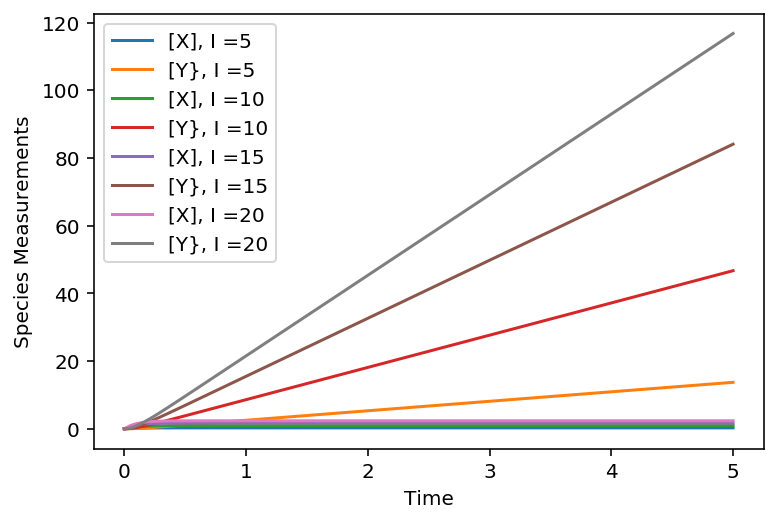

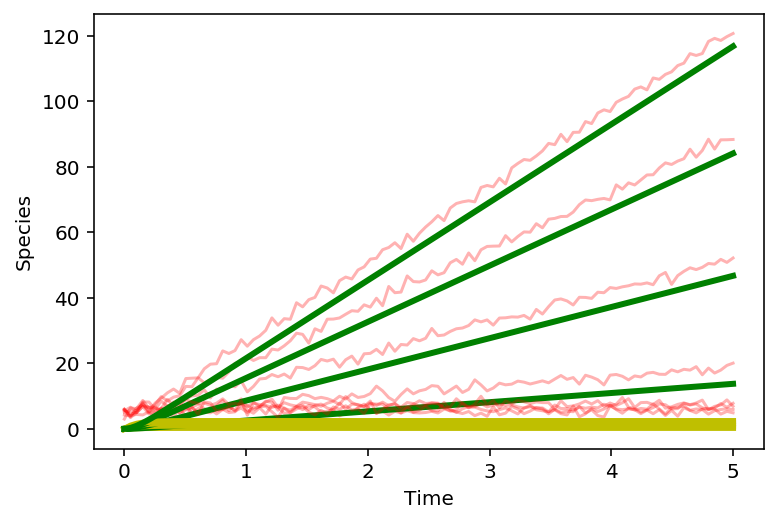

In [25]:
num_trajectories = 4 # each with different initial condition
initial_condition_list = [{'I':5},{'I':10},{'I':15},{'I':20}] 
timepoints = np.linspace(0,5,100)
result_list = []
for init_cond in initial_condition_list:
    M.set_species(init_cond)
    result = py_simulate_model(timepoints, Model = M)
    result_list.append(result)
    plt.plot(timepoints, result['X'], label = '[X], I =' + str(list(init_cond.values())[0]))
    plt.plot(timepoints, result['Y'], label = '[Y}, I =' + str(list(init_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('Species Measurements')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i]['X'] + np.random.normal(5, 1, size = np.shape(result['X']))
    exp_data['Y' + str(i)] = result_list[i]['Y'] + np.random.normal(5, 1, size = np.shape(result['Y']))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, exp_data['Y' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i]['X'], 'y', linewidth = 3)
    plt.plot(timepoints, result_list[i]['Y'], 'g', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Species')
plt.show()
exp_data.to_csv('data/multiple_measurements.csv')


Here's how the CSV file looks:

In [26]:
exp_data

timepoints        X0         Y0        X1         Y1        X2         Y2  \
0     0.000000  5.719872   5.899863  5.477076   5.984552  5.001892   2.984810   
1     0.050505  4.070355   4.519136  6.603685   3.673420  5.516185   6.371155   
2     0.101010  4.392291   5.033705  5.284636   6.389266  4.932360   6.165581   
3     0.151515  4.235154   6.819943  7.911025   7.219758  6.795320   8.663099   
4     0.202020  5.226625   4.542561  5.112909   6.706878  6.506845   6.242086   
5     0.252525  3.730896   5.408332  6.705672   4.857079  6.324380   7.333364   
6     0.303030  6.134674   6.367353  5.362426   6.154340  5.604387   9.835464   
7     0.353535  5.132889   4.738824  6.987139   8.990434  5.411932   8.489279   
8     0.404040  3.537768   8.183733  6.462029   6.979559  6.568515   9.665276   
9     0.454545  6.432229   4.775435  4.823526   7.478183  5.835457  10.114369   
10    0.505051  3.771359   5.774722  6.857194   9.136100  6.033649  12.952080   
11    0.555556  6.452630   6.625102  4.820484  10.048209  6.575863  12.867308   
12    0.606061  5.097195   7.473384  6.257999  10.284482  4.475104  15.589310   
13    0.656566  5.153417   6.138300  5.024239  11.902455  8.209514  14.039296   
14    0.707071  4.877120   5.459653  5.966997   9.425731  7.885387  14.966287   
15    0.757576  5.928886   6.923169  4.559994  12.126603  5.465729  15.673629   
16    0.808081  5.984549   8.677807  5.881108  11.792155  5.961929  15.455928   
17    0.858586  4.965142   5.563830  7.030040  13.252354  6.612610  17.361175   
18    0.909091  5.192507   7.538986  5.417075  12.833618  5.678909  20.015280   
19    0.959596  7.563760   9.139491  6.364219  14.631591  8.536917  20.286333   
20    1.010101  5.728683   6.738618  5.005984  11.292704  4.164768  21.945601   
21    1.060606  4.761753   8.024954  6.379714  12.955057  7.914784  20.868717   
22    1.111111  6.460743   6.838075  6.716356  15.216876  7.411619  21.724303   
23    1.161616  4.501236   8.443027  6.910885  15.397753  7.149698  21.714048   
24    1.212121  7.104524   8.092395  5.212566  16.582509  6.515467  24.335506   
25    1.262626  6.574967   5.701353  3.542452  15.899585  7.224648  24.060581   
26    1.313131  4.742294   9.574797  6.389336  16.724332  6.169527  25.342017   
27    1.363636  5.058987   9.288212  4.883259  15.503073  5.699278  26.897902   
28    1.414141  6.779541   9.231004  6.075762  18.785045  6.850123  29.186151   
29    1.464646  5.867094  10.537788  6.795014  18.702698  7.230599  28.840434   
..         ...       ...        ...       ...        ...       ...        ...   
70    3.535354  5.939617  15.183667  5.825246  39.329014  7.260023  64.242876   
71    3.585859  5.053345  16.283479  4.622208  39.657645  6.208345  64.812909   
72    3.636364  5.384900  15.114370  4.240465  39.049052  6.162493  64.851630   
73    3.686869  5.224589  15.652441  6.965725  37.808034  5.711076  66.176614   
74    3.737374  6.820422  13.658191  3.675053  40.158498  6.668114  68.440996   
75    3.787879  4.841714  16.360687  4.605493  40.112981  6.276913  69.862671   
76    3.838384  5.812597  15.795824  6.195166  39.821924  6.636970  69.656120   
77    3.888889  4.038063  14.992335  5.278406  41.706646  6.387247  70.061153   
78    3.939394  3.589827  13.405144  6.057398  41.548924  7.502326  70.331149   
79    3.989899  7.023512  16.389580  7.212885  43.124179  6.919055  69.895383   
80    4.040404  6.057797  16.593898  5.888875  42.856292  7.516285  74.473522   
81    4.090909  5.855907  16.043585  4.764013  43.350947  9.566002  73.167714   
82    4.141414  6.099792  14.948529  6.302833  43.677058  6.580992  75.101093   
83    4.191919  5.875101  16.154834  5.726441  44.232493  6.234314  74.441324   
84    4.242424  4.632160  15.834521  6.223884  44.160848  5.101561  75.975163   
85    4.292929  5.733567  16.990841  5.999626  44.551920  5.741128  77.498326   
86    4.343434  4.620402  17.242510  7.585623  43.996172  6.473912  77.564928   
87    4.393939  5.861099  16.662317

Now, we load this CSV file in the appropriate format (a list of dataframes where each dataframe corresponds to an initial condition and each dataframe consists of both measurements $X$ and $Y$)

In [27]:
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/multiple_measurements.csv', usecols = ['timepoints', 'X'+str(i),'Y'+str(i)])
    df.columns = ['timepoints', 'X', 'Y']
    exp_data.append(df)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:21<00:00, 48.93it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
{'Autocorrelation time for each parameter': array([61.99849666, 50.52910035, 59.07310117, 60.24869916]), 'Acceptance fraction (fraction of steps that were accepted)': array([0.52175, 0.53425, 0.525  , 0.5105 , 0.5375 , 0.50675, 0.503  ,
       0.51125, 0.49725, 0.09525, 0.5215 , 0.49975, 0.5185 , 0.52325,
       0.508  , 0.508  , 0.51975, 0.51625, 0.52225, 0.50825])}
Parameter posterior distribution convergence plots:


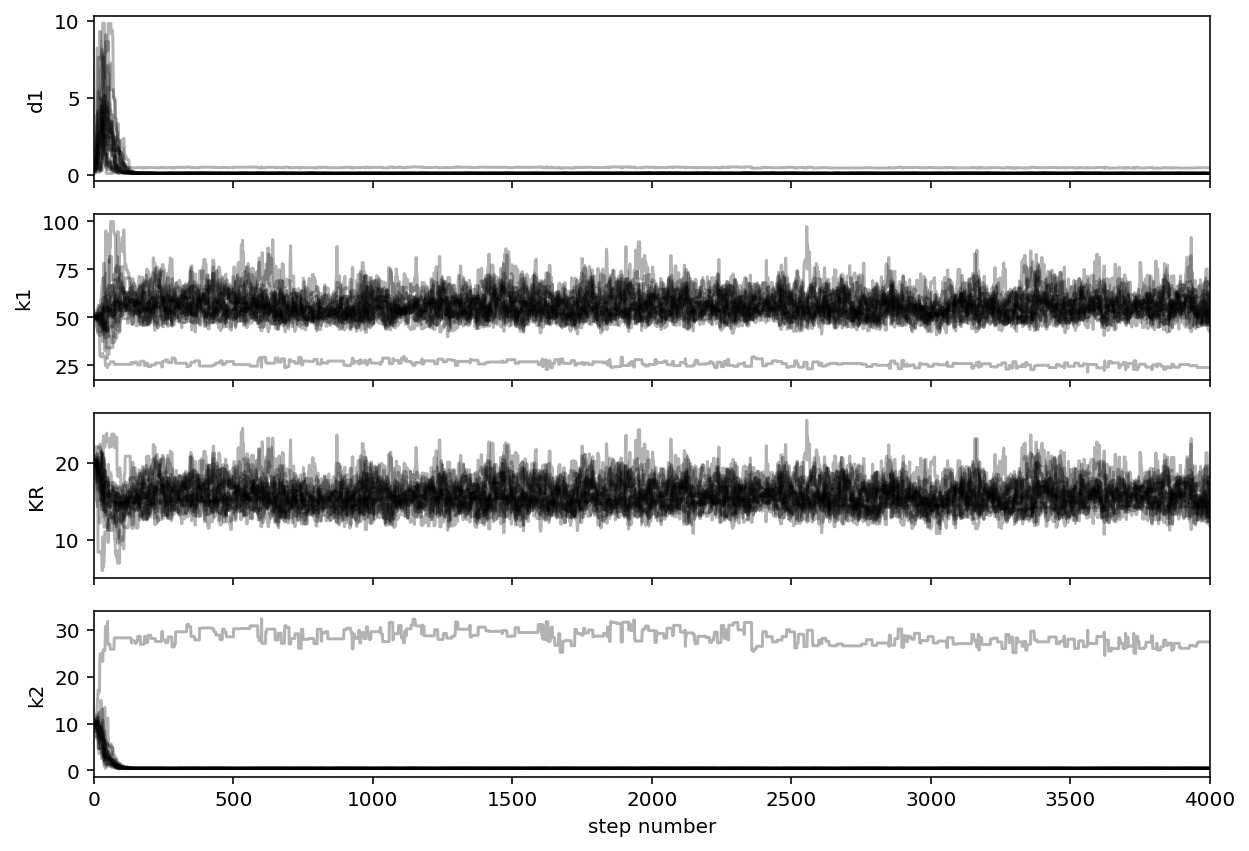

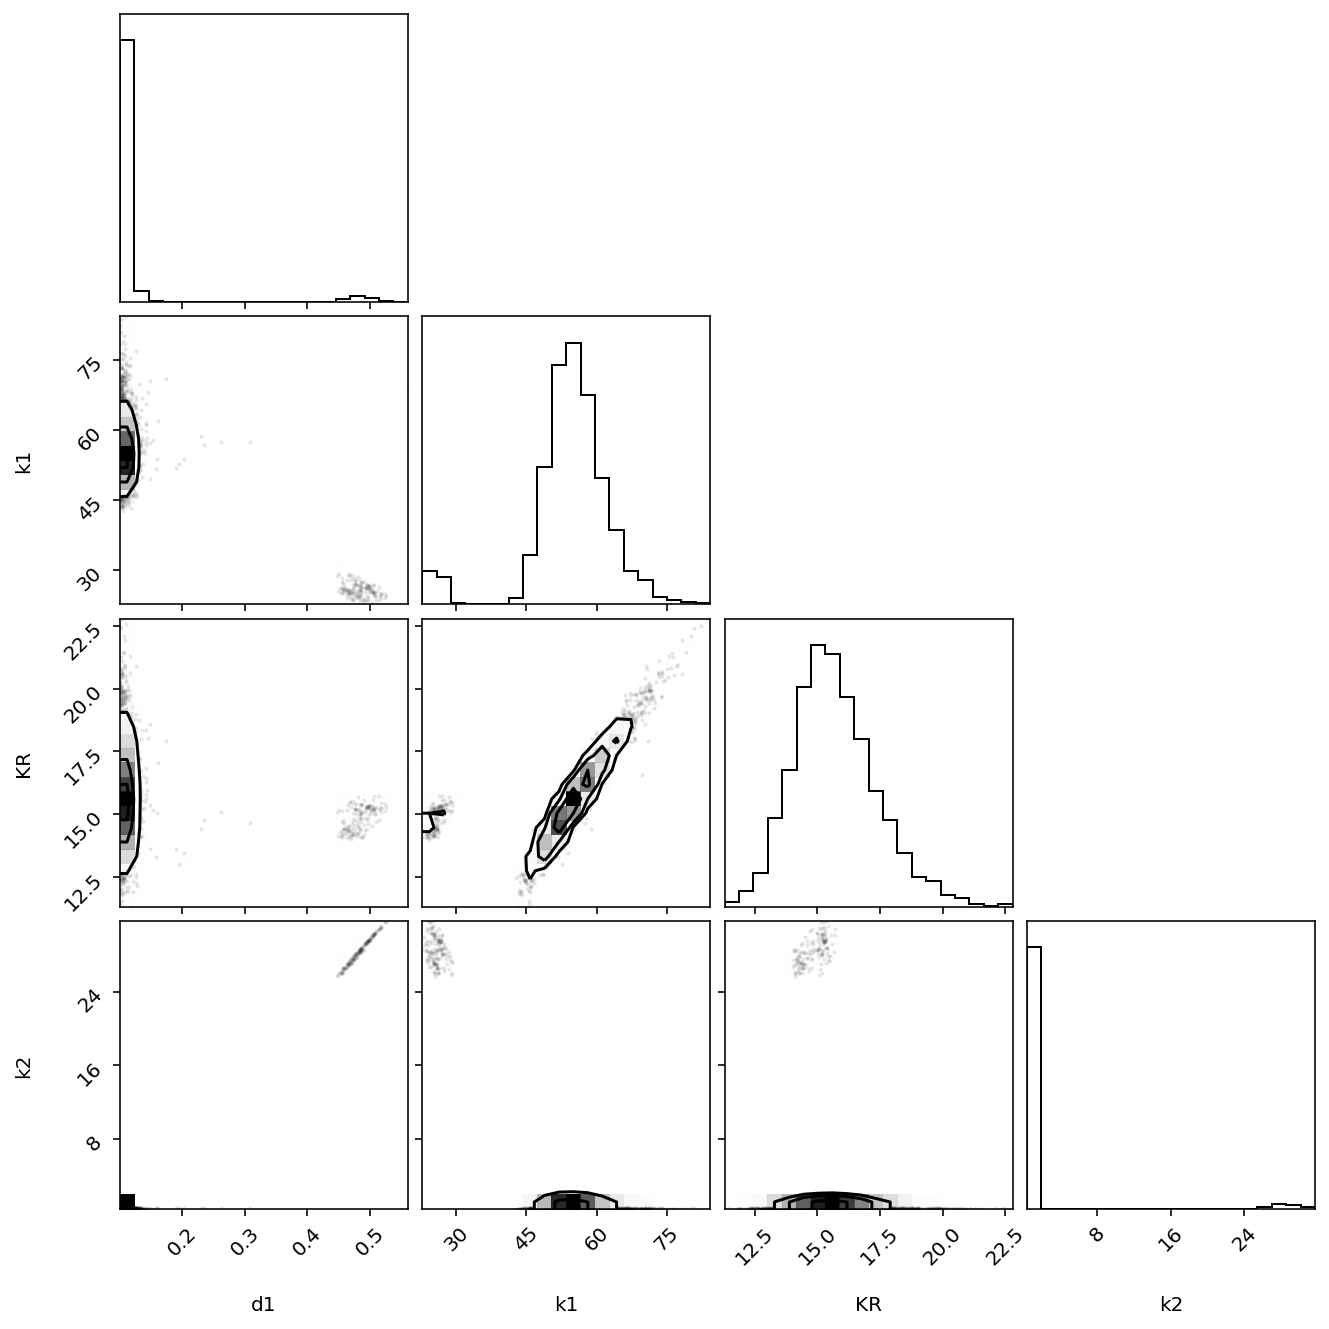

In [28]:
from bioscrape.inference import py_inference
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100], 'k2':['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X','Y'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 20, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
                            params_to_estimate = ['d1','k1','KR', 'k2'], prior = prior, convergence_check = True)


Finally, bioscrape inference also allows stochastic simulations! So, you can run a stochastic inference by simply changing the `sim_type` argument to `stochastic` instead of `deterministic`. 

# Stochastic Inference 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.93it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file. Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


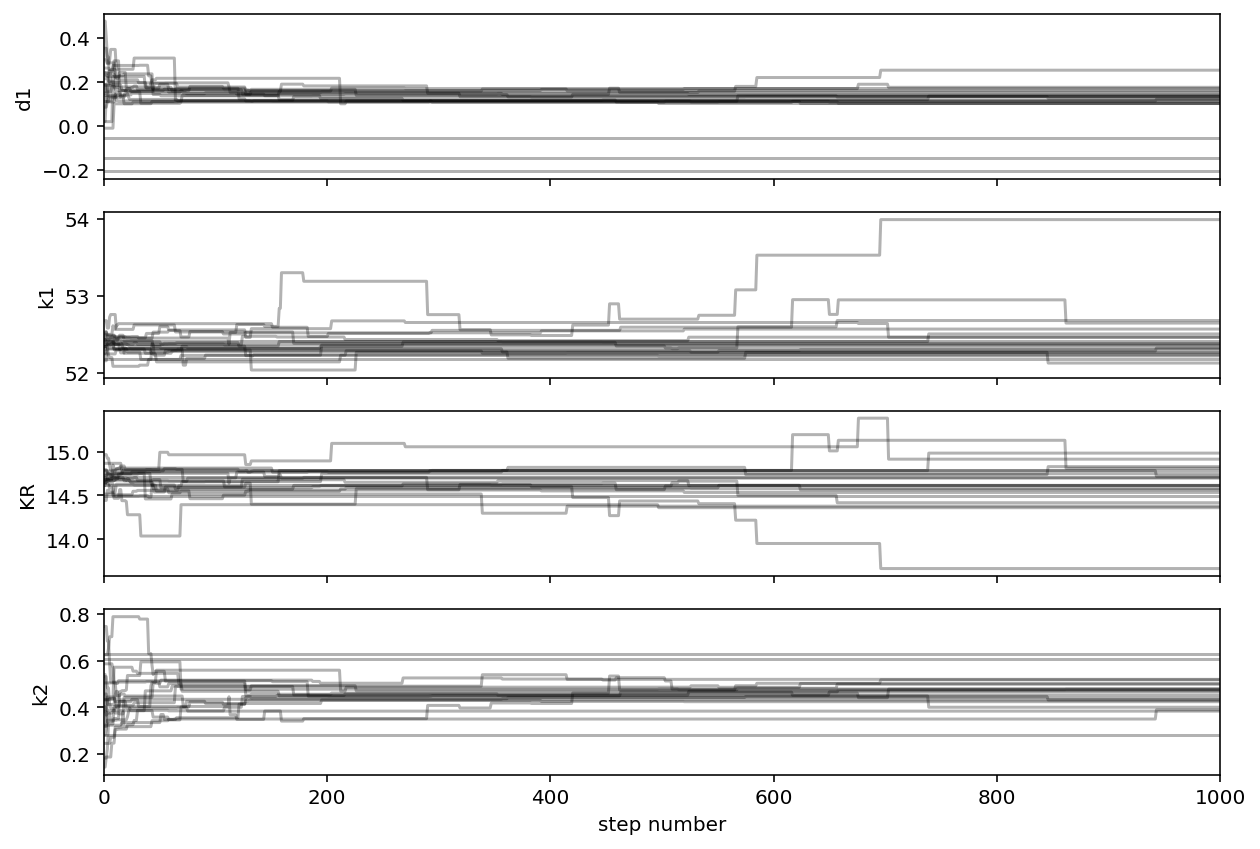

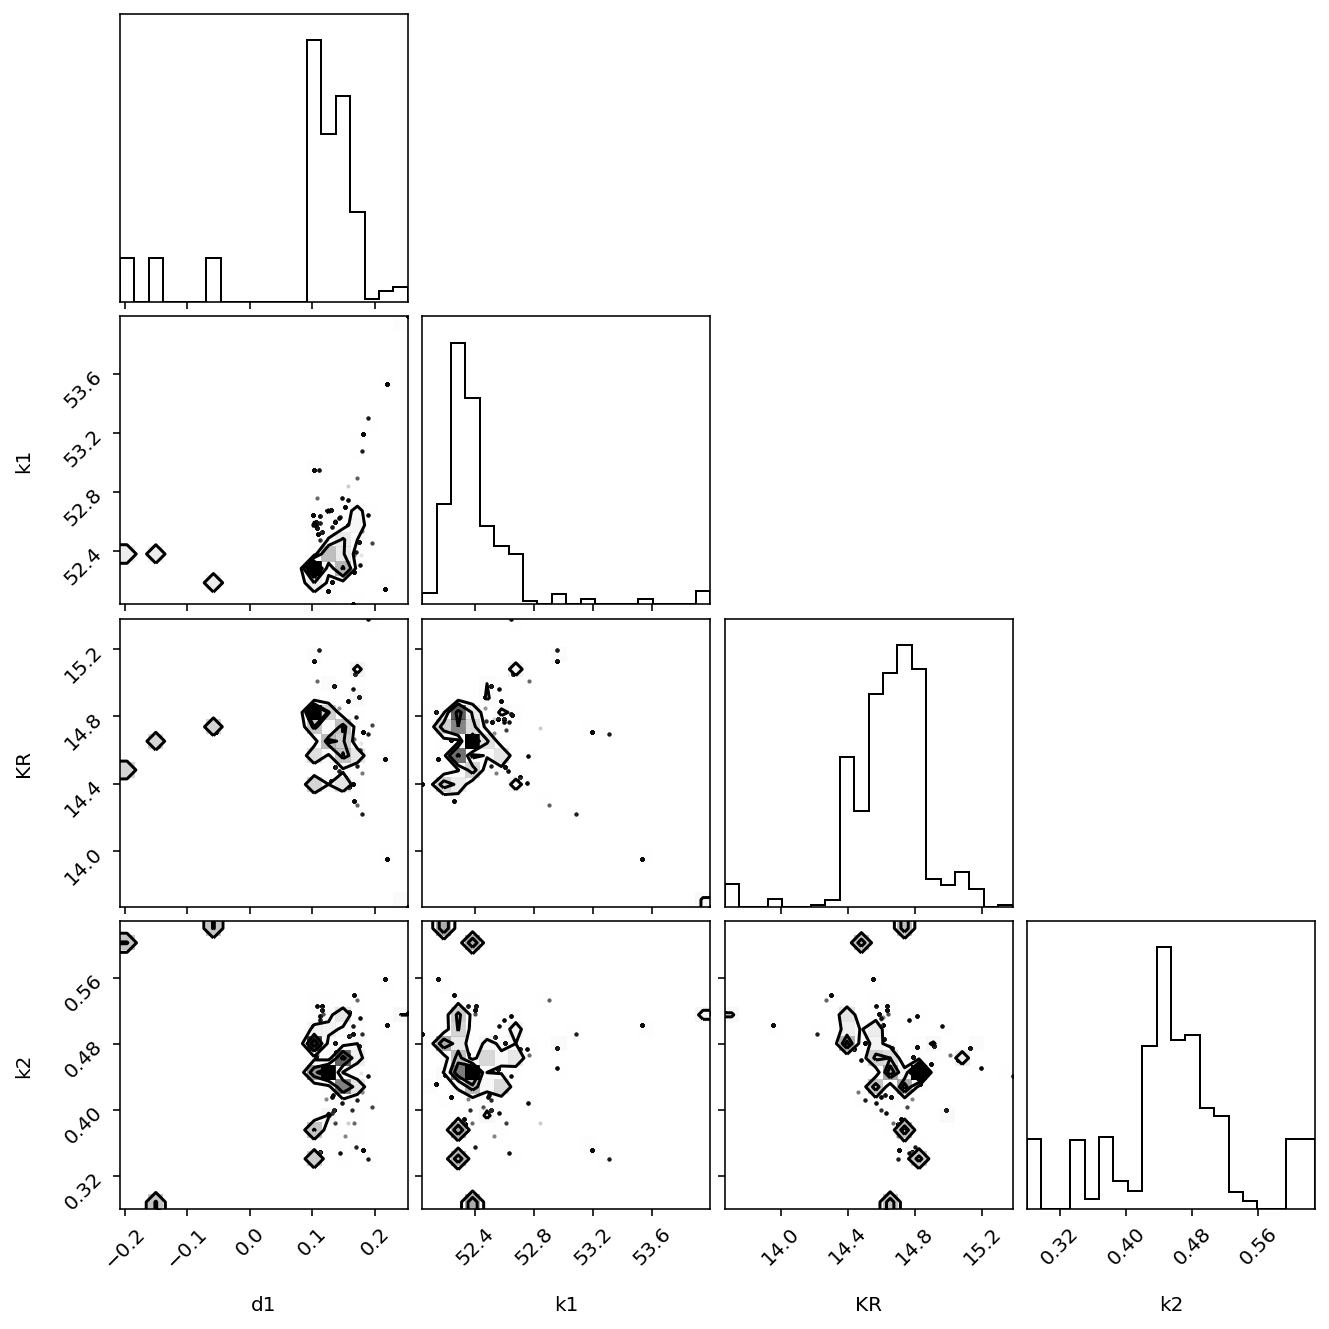

In [29]:
from bioscrape.inference import py_inference
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100], 'k2':['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X','Y'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 20, init_seed = 0.15, nsteps = 1000, sim_type = 'stochastic',
                            params_to_estimate = ['d1','k1','KR', 'k2'], prior = prior, convergence_check = False)


That is not all though! Bioscrape Inference can do more:

## Maximum-Likelihood estimates (such as least-squares): Bioscrape Inference is compatible with the Python LMFit package. Check out the notebook: `OD data using least squares(LMFit example).ipynb`.

1. All examples above are available as individual notebooks at the following location: `bioscrape/inference examples/individual examples/`

Check out our Github page for more information: https://github.com/biocircuits/bioscrape/
